In [1]:
from sarpyx.utils.zarr_utils import ProductHandler
import time
import psutil
import gc
import numpy as np

In [2]:
def get_memory_usage() -> float:
    """Get current memory usage in MB."""
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024

def analyze_visualization_performance(handler: ProductHandler, 
                                    arrays: list[str], 
                                    size_configs: list[tuple[tuple[int, int], tuple[int, int]]],
                                    plot_type: str = 'magnitude') -> None:
    """Analyze memory and time performance for different array sizes."""
    
    print(f"=== Performance Analysis for {len(arrays)} arrays ===")
    print(f"Arrays: {arrays}")
    print(f"Plot type: {plot_type}")
    print("-" * 60)
    
    for i, (rows, cols) in enumerate(size_configs):
        print(f"\nTest {i+1}: rows={rows}, cols={cols}")
        
        # Calculate expected data size
        row_span = rows[1] - rows[0]
        col_span = cols[1] - cols[0]
        expected_size_mb = (row_span * col_span * len(arrays) * 8) / (1024 * 1024)  # 8 bytes for complex64
        print(f"Expected data size: {expected_size_mb:.2f} MB")
        
        # Measure memory before
        gc.collect()
        mem_before = get_memory_usage()
        
        # Time the visualization
        start_time = time.time()
        
        try:
            handler.visualize_arrays(arrays, 
                                   rows=rows, 
                                   cols=cols, 
                                   plot_type=plot_type,
                                   vminmax='auto',
                                   figsize=(20, 5))
            
            end_time = time.time()
            
            # Measure memory after
            mem_after = get_memory_usage()
            
            # Calculate metrics
            execution_time = end_time - start_time
            memory_increase = mem_after - mem_before
            
            print(f"Execution time: {execution_time:.3f} seconds")
            print(f"Memory before: {mem_before:.2f} MB")
            print(f"Memory after: {mem_after:.2f} MB")
            print(f"Memory increase: {memory_increase:.2f} MB")
            print(f"Memory efficiency: {expected_size_mb/memory_increase:.2f}x" if memory_increase > 0 else "N/A")
            
        except Exception as e:
            print(f"Error: {e}")
            
        # Clean up
        gc.collect()

# Load the data
filepath = '/Data_large/marine/PythonProjects/SAR/sarpyx/data/3_parsed/S1A_S1_RAW__0SDV_20230530T123131_20230530T123157_048763_05DD44_0C6D.SAFE/s1a-s1-raw-s-vh-20230530t123131-20230530t123157-048763-05dd44.zarr'
p = ProductHandler(filepath)

# Display basic info
print("Available arrays:", p.info['available_arrays'])
print("Array shapes:", p.array_shapes)
print(f"Initial memory usage: {get_memory_usage():.2f} MB")

Available arrays: ['rcmc', 'az', 'rc', 'raw']
Array shapes: {'az': (46775, 25774), 'raw': (46775, 25774), 'rc': (46775, 25774), 'rcmc': (46775, 25774)}
Initial memory usage: 692.98 MB


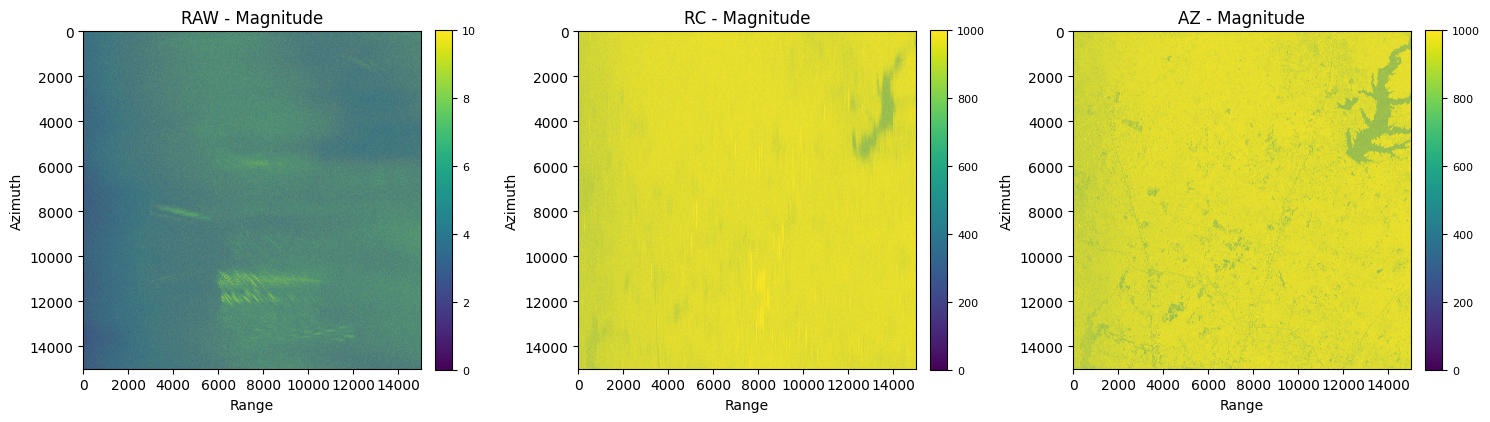

In [3]:
p.visualize_arrays(array_names=['raw','rc','az'], rows=(0,15000), cols=(0,15000))

# Performance Analysis

In [ ]:
import os
import zarr

# Define different size configurations for testing with performance optimizations
size_configs = [   
    # Extra Large: 10000x10000 region (if data allows)
    ((2000, 12000), (2000, 12000)),
]

# Test with different array combinations
array_configs = [
    # ['raw'],  # Single array
    # ['raw', 'rc'],  # Two arrays
    # ['raw', 'rc', 'rcmc'],  # Three arrays
    ['raw', 'rc', 'rcmc', 'az'],  # Four arrays
]

# Performance optimization tricks
def optimize_reading_performance() -> None:
    """Apply performance optimizations for faster data reading."""
    
    # Set environment variables for better I/O performance
    os.environ['ZARR_V3_EXPERIMENTAL_API'] = '1'
    os.environ['NUMCODECS_MAX_BUFFER_SIZE'] = '134217728'  # 128MB buffer
    
    # Configure blosc compression for better performance
    try:
        import blosc
        blosc.set_nthreads(4)  # Use 4 threads for compression
    except ImportError:
        print('Warning: blosc not available for optimization')

# Apply optimizations
optimize_reading_performance()

# Pre-warm the cache by reading a small sample from each array
print('Pre-warming cache...')
for array_name in ['raw', 'rc', 'rcmc', 'az']:
    try:
        # Read a small chunk to populate cache
        sample = p.zarr_manager.get_array_data(array_name, 
                                              rows=(2000, 2100), 
                                              cols=(2000, 2100))
        del sample
        gc.collect()
    except Exception as e:
        print(f'Warning: Could not pre-warm {array_name}: {e}')

print("=== COMPREHENSIVE PERFORMANCE ANALYSIS ===\n")

for arrays in array_configs:
    # Additional optimization: process arrays in chunks if too large
    if len(arrays) > 2:
        print(f"Processing {len(arrays)} arrays with chunked reading optimization...")
        
        # Override the analyze function to use chunked reading
        def chunked_analyze(handler: ProductHandler, 
                          arrays: list[str], 
                          size_configs: list[tuple[tuple[int, int], tuple[int, int]]], 
                          plot_type: str = 'magnitude') -> None:
            """Analyze with chunked reading for better memory efficiency."""
            for i, (rows, cols) in enumerate(size_configs):
                row_span = rows[1] - rows[0]
                col_span = cols[1] - cols[0]
                
                # Use smaller chunks for very large data
                if row_span * col_span > 50_000_000:  # 50M pixels
                    print(f"Large data detected, using optimized chunked reading...")
                    
                    # Split into smaller chunks
                    chunk_size = 5000
                    for r_start in range(rows[0], rows[1], chunk_size):
                        r_end = min(r_start + chunk_size, rows[1])
                        chunk_rows = (r_start, r_end)
                        
                        print(f"Processing chunk: rows {chunk_rows}")
                        analyze_visualization_performance(handler, arrays, 
                                                        [(chunk_rows, cols)], 
                                                        plot_type)
                        gc.collect()  # Clean up after each chunk
                else:
                    analyze_visualization_performance(handler, arrays, size_configs, plot_type)
        
        chunked_analyze(p, arrays, size_configs, 'magnitude')
    else:
        analyze_visualization_performance(p, arrays, size_configs, 'magnitude')
    
    print("\n" + "="*80 + "\n")

In [ ]:
# Test different plot types with fixed size
print("=== PLOT TYPE COMPARISON ===")
print("Testing different plot types with fixed size (4000x4000)")

test_arrays = ['raw', 'rc']
test_size = ((4000, 8000), (4000, 8000))
plot_types = ['magnitude', 'phase', 'real', 'imag']

for plot_type in plot_types:
    print(f"\n--- Testing plot_type: {plot_type} ---")
    
    gc.collect()
    mem_before = get_memory_usage()
    start_time = time.time()
    
    try:
        p.visualize_arrays(test_arrays, 
                          rows=test_size[0], 
                          cols=test_size[1], 
                          plot_type=plot_type,
                          vminmax='auto',
                          figsize=(15, 5))
        
        end_time = time.time()
        mem_after = get_memory_usage()
        
        print(f"Execution time: {end_time - start_time:.3f} seconds")
        print(f"Memory increase: {mem_after - mem_before:.2f} MB")
        
    except Exception as e:
        print(f"Error with {plot_type}: {e}")
    
    gc.collect()

In [ ]:
# Memory scaling analysis
print("=== MEMORY SCALING ANALYSIS ===")
print("Testing how memory scales with data size")

scaling_sizes = [
    ((4000, 4500), (4000, 4500)),    # 500x500 = 0.25M pixels
    ((4000, 5000), (4000, 5000)),    # 1000x1000 = 1M pixels  
    ((4000, 6000), (4000, 6000)),    # 2000x2000 = 4M pixels
    ((4000, 7000), (4000, 7000)),    # 3000x3000 = 9M pixels
    ((4000, 8000), (4000, 8000)),    # 4000x4000 = 16M pixels
]

test_arrays = ['raw', 'rc']
results = []

for rows, cols in scaling_sizes:
    row_span = rows[1] - rows[0]
    col_span = cols[1] - cols[0]
    total_pixels = row_span * col_span
    
    gc.collect()
    mem_before = get_memory_usage()
    start_time = time.time()
    
    try:
        p.visualize_arrays(test_arrays, 
                          rows=rows, 
                          cols=cols, 
                          plot_type='magnitude',
                          vminmax='auto',
                          figsize=(10, 5))
        
        end_time = time.time()
        mem_after = get_memory_usage()
        
        execution_time = end_time - start_time
        memory_increase = mem_after - mem_before
        
        results.append({
            'pixels': total_pixels,
            'time': execution_time,
            'memory': memory_increase,
            'size': f"{row_span}x{col_span}"
        })
        
        print(f"Size: {row_span}x{col_span} ({total_pixels/1e6:.1f}M pixels)")
        print(f"  Time: {execution_time:.3f}s")
        print(f"  Memory: {memory_increase:.2f} MB")
        print(f"  Time/Mpixel: {execution_time/(total_pixels/1e6):.3f}s")
        print(f"  Memory/Mpixel: {memory_increase/(total_pixels/1e6):.2f} MB")
        
    except Exception as e:
        print(f"Size: {row_span}x{col_span} - Error: {e}")
    
    gc.collect()

# Summary analysis
if results:
    print("\n=== SCALING SUMMARY ===")
    print("Pixel count vs Performance:")
    for result in results:
        mpixels = result['pixels'] / 1e6
        time_per_mpix = result['time'] / mpixels
        mem_per_mpix = result['memory'] / mpixels
        print(f"{result['size']:>10} | {mpixels:>6.1f}M | {result['time']:>6.3f}s | {result['memory']:>7.2f}MB | {time_per_mpix:>6.3f}s/M | {mem_per_mpix:>6.2f}MB/M")